In [105]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
import warnings
# ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [106]:
class kau:
    def __init__(self,start_tier,end_tier):
        '''
        Initializes the kau class with the specified start and end tiers.

        Parameters:
        - start_tier (int): The starting tier for the algorithm.
        - end_tier (int): The ending tier for the algorithm.
        '''
        self.start_tier = start_tier
        self.end_tier = end_tier
        self.base_mean = 1
        self.base_var = 0.5
        self.mean_multiplier = 2
        self.var_multiplier = 2
        self.uuid_map = {}
        self.data = pd.DataFrame()
        self.total_num = 0
        self.G = nx.DiGraph()

    def get_nums(self):
        '''
        Calculate the total required number of tier n nodes.
        '''
        nums = []
        nums.append(pow(2,self.end_tier-1)-pow(2,self.start_tier-1))

        for i in range(self.end_tier-1):
            nums_n = int(nums[-1]/2) 
            if i == self.start_tier-2:
                nums.append(nums_n+1) # original node inclusive
            else:
                nums.append(max(2,nums_n)) # 2 nodes in the last tier to avoid pd.DataFrame error

        self.nums = nums
    
    def generate_data(self):
        '''
        Generate the data for each tier using normal distribution.
        '''
        df = pd.DataFrame(columns=['UUID', 'Tier', 'Price'])
        mean, var = self.base_mean, self.base_var

        for tier in range(self.end_tier):

            # Generate data for this tier
            required_num = self.nums[tier]
            prices = []
            while len(prices) < required_num:
                new_prices = np.random.normal(mean, var, size=required_num - len(prices))
                new_prices = new_prices[new_prices > mean - var] # Remove outliers
                prices.extend(np.round(new_prices, 3))
            print('Generated', len(prices), 'tier', tier + 1, 'items.')

            uuids = range(self.total_num + 1, self.total_num + len(prices) + 1)
            tiers = [tier + 1] * len(prices)
            tier_df = pd.DataFrame({'UUID': uuids, 'Tier': tiers, 'Price': prices})
            df = pd.concat([df, tier_df])

            mean *= self.mean_multiplier
            var *= self.var_multiplier
            self.total_num += len(prices)

        df = df.sort_values(['Tier', 'Price']).set_index('Tier')

        self.original_data = df.__deepcopy__()
        self.data = df
    
    def fused_node(self,current_tier,id_start) -> pd.DataFrame:
        '''
        Combine 2 nodes in the current tier to a fused node.

        Parameters:
        - current_tier (int): The current tier.
        - id_start (int): The starting index of the nodes to be fused.

        Returns:
        - pd.DataFrame: A dataframe with the fused node.
        '''
        left_elem =  self.data.loc[current_tier].iloc[id_start] # id_start serves as left ptr
        right_elem = self.data.loc[current_tier].iloc[id_start+1]

        new_uuid = self.total_num + 1
        new_price = left_elem['Price'] + right_elem['Price']
        new_tier = current_tier + 1

        self.uuid_map[new_uuid] = [left_elem['UUID'],right_elem['UUID']]
        return pd.DataFrame({'UUID': [new_uuid], 'Tier': [new_tier], 'Price': [new_price]}).set_index('Tier')

        
    def insert_fused_node(self,next_tier,fused_node):
        '''
        Insert fused node to the dataframe.

        Parameters:
        - next_tier (int): The next tier.
        - fused_node (pd.DataFrame): The fused node to be inserted.

        Returns:
        - int: The inserted position.
        '''
        for i in range(len(self.data.loc[next_tier])):
            if pd.DataFrame(self.data.loc[next_tier]).iloc[i]['Price'] >= fused_node.iloc[0]['Price']: # find the first node with higher price

                for j in range(len(self.data.loc[next_tier])-1,i,-1):
                    self.data.loc[next_tier].iloc[j] = self.data.loc[next_tier].iloc[j-1] # shift right

                self.data.loc[next_tier].iloc[i] = fused_node.iloc[0] # insert fused node
                return i
        return -1

    
    def insertion_pop(self) -> pd.DataFrame:
        '''
        Repeatedly insert fused nodes until the corresponding size is achieved.
        '''
        current_tier = 1
        while current_tier < self.end_tier:
            print('Tier',current_tier,'started...')

            # insert original node (to the leftmost of its tier)
            if current_tier == self.start_tier:
                original = pd.DataFrame([['0',current_tier,0]],columns = ['UUID','Tier','Price']).set_index('Tier')
                _ = self.insert_fused_node(current_tier,original) 

            required_num = self.nums[current_tier]
            for i in range(0,len(self.data.loc[current_tier]),2): # left ptr step = 2
                fused = self.fused_node(current_tier,i)
                inserted_id = self.insert_fused_node(current_tier+1,fused)
                # if the inserted node is the last node or the required size is achieved, break
                if inserted_id == -1 or inserted_id > required_num-1: 
                    break

                self.total_num += 1

            print('Tier',current_tier,'is completed.')
            current_tier += 1

        print('All tiers are completed.')
    
    def get_total_cost(self):
        '''
        Calculate the total cost and direct cost.
        '''
        self.total_cost = self.data.loc[self.end_tier].iloc[0]['Price']
        self.direct_cost = self.data.loc[self.end_tier].iloc[1]['Price']

    def construct_tree(self):
        '''
        Construct the tree.
        '''
        res = self.data.loc[self.end_tier].iloc[0]['UUID']
        self.G.add_node(res)
        queue = [res]
        origin = None

        # Populate the graph and labels using BFS
        while queue:
            node = queue.pop(0)
            children = self.uuid_map.get(node, [])
            for child in children:
                if child == '0':
                    origin = child
                self.G.add_edge(node, child)
                queue.append(child)

        self.pos = graphviz_layout(self.G, prog='dot')

        self.leaf_nodes = [n for n in self.G if self.G.out_degree(n) == 0 and n != '0']
        self.original_node = origin
        self.non_leaf_nodes = [n for n in self.G if self.G.out_degree(n) != 0]

        # Graph layout
        self.G = nx.DiGraph.reverse(self.G)

        self.auctions = self.leaf_nodes

    def plot_tree(self):
        '''
        Plot the tree.
        '''
        nx.draw_networkx_nodes(self.G, self.pos, nodelist=self.leaf_nodes, node_color='#009999', node_size=500, alpha=0.8)
        nx.draw_networkx_nodes(self.G, self.pos, nodelist=self.non_leaf_nodes, node_color='#00CC66', node_size=500, alpha=0.8)
        nx.draw_networkx_nodes(self.G, self.pos, nodelist=self.original_node, node_color='#00CCCC', node_size=500, alpha=0.8)

        nx.draw_networkx_edges(self.G, self.pos, width=1.0, alpha=0.5)

        nx.draw_networkx_labels(self.G, self.pos, labels={n: n for n in self.leaf_nodes} , font_size=10)

        plt.axis('off')


    def run(self):
        '''
        Run the kau algorithm.
        '''
        self.get_nums()
        self.generate_data()
        self.insertion_pop()
        self.get_total_cost()
        self.construct_tree()

### Visualization

Generated 124 tier 1 items.
Generated 62 tier 2 items.
Generated 32 tier 3 items.
Generated 16 tier 4 items.
Generated 8 tier 5 items.
Generated 4 tier 6 items.
Generated 2 tier 7 items.
Generated 2 tier 8 items.
Tier 1 started...
Tier 1 is completed.
Tier 2 started...
Tier 2 is completed.
Tier 3 started...
Tier 3 is completed.
Tier 4 started...
Tier 4 is completed.
Tier 5 started...
Tier 5 is completed.
Tier 6 started...
Tier 6 is completed.
Tier 7 started...
Tier 7 is completed.
All tiers are completed.
The total cost is: 70.033
The direct cost is: 155.766


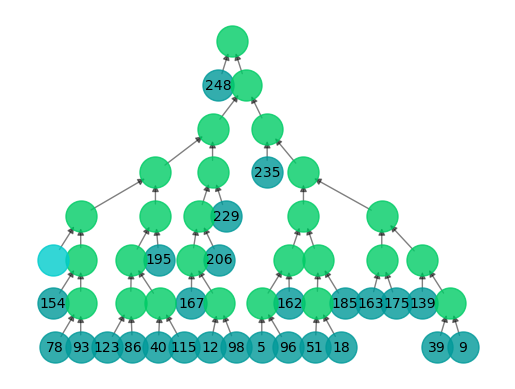

In [107]:
start_tier = 3
end_tier = 8

task = kau(start_tier,end_tier)
task.run()
print('The total cost is:',task.total_cost)
print('The direct cost is:',task.direct_cost)
task.plot_tree()

### Local maxima using greedy algorithm

It can be proven the objective is equivalent to obtaining task.nums[0] tiers of attributes.

In [108]:
class kau_greedy:
    def __init__(self,df,req):
        '''
        Initializes the greedy class with the specified dataframe and required number of auctions.

        Parameters:
        - df (pd.DataFrame): The dataframe containing the auction data.
        - req (int): The required number of auctions.
        '''
        self.df = df
        self.req = req
    def equivalent_tier(self, x): 
        '''
        Calculate the equivalent tier of the auction.
        '''
        return 2**(x['Tier']-1)

    def calculate_coeff(self, x):
        '''
        Calculate the cost-effectiveness of the auction.
        '''
        coeff =  x['Price']/x['equiv_tier']
        return np.round(coeff,3)
    
    def greedy(self):
        '''
        Calculate the auctions using greedy algorithm.
        '''
        self.greedy_cost = 0
        self.auctions_index = []
        self.tiers = 0  
        for i in range(len(self.df)):
            if self.tiers < self.req: 
                self.tiers += self.df.iloc[i]['equiv_tier']
                self.auctions_index.append(i)
                self.greedy_cost += self.df.iloc[i]['Price']  # Use greedy_cost instead of total_cost
            else:
                break
        self.auctions = self.df.iloc[self.auctions_index]

    def pruning(self):
        '''
        prune the subset of the auctions, where the total equiv_tiers is <= self.tiers-self.req, and the total cost is maximized.
        This is a classic 0-1 knapsack problem.
        '''
        
        # sort by equiv_tier
        excessive_tier = self.tiers-self.req
        potential_prunes = self.auctions.sort_values(['equiv_tier'],ascending=True).reset_index(drop=True)
        if potential_prunes.iloc[0]['equiv_tier'] > excessive_tier:
            return # no need to prune

        # initialize the dp table
        dp = np.zeros((len(potential_prunes), excessive_tier+1))
        dp[0][potential_prunes.iloc[0]['equiv_tier']] = potential_prunes.iloc[0]['Price']
        for i in range(1,len(potential_prunes)):
            for j in range(excessive_tier+1):
                if j >= potential_prunes.iloc[i]['equiv_tier']:
                    dp[i][j] = max(dp[i-1][j],dp[i-1][j-potential_prunes.iloc[i]['equiv_tier']]+potential_prunes.iloc[i]['Price'])
                else:
                    dp[i][j] = dp[i-1][j]

        # backtracking
        pruned_index = []
        i = len(potential_prunes)-1
        j = excessive_tier
        while i > 0 and j > 0:
            if dp[i][j] != dp[i-1][j]:
                pruned_index.append(i)
                j -= potential_prunes.iloc[i]['equiv_tier']
            i -= 1
        pruned_index.append(0)
        pruned_index.sort()

        # drop the pruned auctions
        self.auctions = self.auctions.drop(self.auctions.index[pruned_index]).reset_index(drop=True)
        self.greedy_cost = self.auctions['Price'].sum()
        self.pruned_cost = dp[-1][-1]


    def run(self):
        '''
        Run the greedy algorithm.
        '''
        self.df['equiv_tier'] = self.df.apply(self.equivalent_tier,axis=1) 
        self.df['coeff'] = self.df.apply(self.calculate_coeff,axis=1)
        self.df.sort_values(['coeff'],ascending=[True],inplace=True)
        self.greedy()
        self.pruning()

In [109]:
df = task.original_data.reset_index()
req = task.nums[0] # equivalent tiers needed
greedy = kau_greedy(df,req)
greedy.run()

In [110]:
greedy.df.head()

,Tier,UUID,Price,equiv_tier,coeff
124,2,154,1.025,2,0.512
0,1,78,0.517,1,0.517
1,1,93,0.520,1,0.520
2,1,123,0.521,1,0.521
3,1,86,0.529,1,0.529


In [111]:
greedy_cost = greedy.greedy_cost
greedy_auctions = greedy.auctions
print('The greedy cost is:',greedy_cost)
# print('The greedy auctions are:',greedy_auctions)

The greedy cost is: 75.98


In [112]:
print('The difference in cost is:',np.round(greedy_cost-task.total_cost,3))
print('The difference in auctions is:',set(task.auctions)-set(greedy_auctions))

The difference in cost is: 5.947
The difference in auctions is: {195, 5, 9, 139, 12, 206, 78, 18, 86, 154, 93, 96, 162, 163, 98, 229, 167, 40, 39, 235, 175, 51, 115, 248, 185, 123}
